# Financial Fraud Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import time

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score 
from sklearn.metrics import classification_report,confusion_matrix, recall_score, precision_score
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

### Load Dataset

In [2]:
df = pd.read_csv("fraud.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Columns
- step: Maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps = 744 (30 days simulation).
- type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- amount: Amount of the transaction in local currency.
- nameOrig: Customer who started the transaction.
- oldbalanceOrg: Initial balance before the transaction.
- newbalanceOrig: New balance after the transaction.
- nameDest: Customer who is the recipient of the transaction.
- oldbalanceDest: Initial balance recipient before the transaction. Note that there is no information for customers that start with M (Merchants).
- newbalanceDest: New balance recipient after the transaction. Note that there is no information for customers that start with M (Merchants).
- isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit **by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system**.
- isFlaggedFraud: The business model aims to control massive transfers from one account to another and flags illegal attempts. **An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction**.

In [6]:
df.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

**Findings:**
- There are over 6 million observations.
- There are 11 valiables.
- There are no missing values.
- Most transactions involve amounts less than 1 million.

#### Correct spelling of original column headers for consistency

In [7]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

# Exploratory Data Analysis

### Fraudulent Transactions

In [8]:
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
print("Non-fraudulent transactions: {} % of the dataset.".format(\
                        round(df["isFraud"].value_counts()[0]/len(df) * 100, 2)))
print("Fraudulent transactions: {} % of the dataset.".format(\
                        round(df["isFraud"].value_counts()[1]/len(df) * 100, 2)))

Non-fraudulent transactions: 99.87 % of the dataset.
Fraudulent transactions: 0.13 % of the dataset.


In [10]:
list(df.loc[df["isFraud"] == 1]["type"].drop_duplicates().values)

['TRANSFER', 'CASH_OUT']

In [11]:
dfNotFraud = df.loc[df["isFraud"] == 0]
dfFraud = df.loc[df["isFraud"] == 1]
transferFrauds = df.loc[(df["isFraud"] == 1) & (df["type"] == 'TRANSFER')]
cashoutFrauds = df.loc[(df["isFraud"] == 1) & (df["type"] == 'CASH_OUT')]

In [12]:
print("There are {} fraudulent transfers.".format(len(transferFrauds)))
print("There are {} fraudulent cashouts.".format(len(cashoutFrauds)))

There are 4097 fraudulent transfers.
There are 4116 fraudulent cashouts.


**Findings:**
- The data is highly imbalanced. Most observations in the dataset are of valid transactions, only 0.13% are fraudulent.
- From the dataset, it seems that fraudulent transactions only occur when the transaction type is either TRANSFER or CASH-OUT.

### Flagged as Fraudulent Transactions

In [14]:
df["isFlaggedFraud"].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [15]:
list(df.loc[df["isFlaggedFraud"] == 1]["type"].drop_duplicates().values)

['TRANSFER']

There are 16 transactions that are flagged as fraudulent, all of them are transfers.

### What Makes a Transaction Flagged as Fraudulent?

In [16]:
dfTransfer = df.loc[df["type"] == 'TRANSFER']
dfFlagged = df.loc[df["isFlaggedFraud"] == 1]
dfNotFlagged = df.loc[df["isFlaggedFraud"] == 0]

In [17]:
dfFlagged

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


**In the column description, it is stated that an attempt to transfer more than 200.000 in a single transaction will be flagged as illegal.**

In [18]:
dfFlagged["amount"].min()

353874.22

The minimal amount of transaction that is flagged is 353874.22 (more than 200.000).
***

In [19]:
dfTransfer.loc[dfTransfer["isFlaggedFraud"] == 0]["amount"].max()

92445516.64

But, the highest amount of transfer that is not flagged as fraudulent is 92445516.64 (also more than 200.000).
***

**Findings:**
- It is true that the smallest amount of transfer that is flagged as fraudulent is more than 200.000.
- However, as shown above, a transaction can remain not flagged despite this condition being met.

**The old balance is identical to the new balance in the origin and destination accounts for every TRANSFER where isFlaggedFraud is set.**

In [20]:
len(dfTransfer.loc[(dfTransfer["isFlaggedFraud"] == 0) & \
                   (dfTransfer["oldBalanceOrig"] == dfTransfer["newBalanceOrig"])])

282784

In [21]:
len(dfTransfer.loc[(dfTransfer["isFlaggedFraud"] == 0) & \
                   (dfTransfer["oldBalanceDest"] == dfTransfer["newBalanceDest"])])

4158

**Finding:**
<br>
The old and new balance of the origins and destinations accounts are also identical in other transactions that are not flagged as fraudulent.

**How about the old and new balance in the destination accounts that are all 0 in flagged transactions?**

In [22]:
len(dfTransfer.loc[(dfTransfer["isFlaggedFraud"] == 0) & (dfTransfer["oldBalanceDest"] == 0) & \
                  (dfTransfer["newBalanceDest"] == 0)])

4158

**Finding:**
<br>As shown above, there are transfers where oldBalanceDest and newBalanceDest are both 0, but these transactions are not flagged as fraudulent.

Duplicate customer names don't exist within transactions where isFlaggedFraud is 1, but duplicate customer names exist within transactions where isFlaggedFraud is 0. 
<br>
**So, are the customers being flagged based on the number of transaction that they had done?**

In [23]:
dfFlagged["nameOrig"].isin(pd.concat([dfNotFlagged["nameOrig"], dfNotFlagged["nameDest"]])).any()

False

Have originators of transactions flagged as fraud transacted more than once? **False.**
***

In [24]:
dfNotFlagged["nameOrig"][~dfNotFlagged.duplicated("nameOrig")].any()

True

Are there originators that only transacted once but are not flagged as frauds? **True**.
***

According to the column descripstion, the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. So this requires an originator to transfer to a destination account, and then the destination account makes a cash-out transaction. 

In [25]:
dfFlagged["nameDest"].isin(pd.concat([dfNotFlagged["nameOrig"]])).any()

False

Have destinations for transactions flagged as fraud initiated other transactions? **False.**
***

In [26]:
dfFlagged["nameDest"].isin(pd.concat([dfNotFlagged["nameDest"]])).any()

True

Have destinations for transactions flagged as fraud have been a destination for another transaction? **True.**
***

In [27]:
sum(dfFlagged["nameDest"].isin(pd.concat([dfNotFlagged["nameDest"]])))

2

How many destination accounts of transactions flagged as fraud have been destination accounts more than once? **2 accounts.**
***

**Findings:**
- All the originators account flagged as fraud only transacted once, but there are also originators that transacted only once but are not flagged as fraudulent.
- According to the description, the fraud scheme aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. This requires an originator to transfer to a destination account, and then the destination account makes a cash-out transaction. However, there are not destinations for transactions flagged as fraud that initiated other transactions.
- There are 2 destination accounts of 16 that are flagged as fraud have been destination accounts more than once, clearly 'isFlaggedFraud' being set is independent of whether a destination account has been used before or not.

**Conclusion:**
- **There is no clear/straighforward reasoning why a transaction is marked as fraudulent.**
- **Although all the transanctions flagged as fraud are really frauds (isFraud = 1), since there are only 16 transactions flagged out of 8213 fraudulent transactions in a seemingly meaningless way, we can can treat isFlaggedFraud as insignificant and discard it without losing valuable information.**

## Characteristics of Fraudulent Transactions

### Fraudulent Transfers and Cash-outs

From the data description, the scheme for committing fraud involves first making a TRANSFER to a (fraudulent) account which in turn conducts a CASH_OUT. CASH_OUT involves transacting with a merchant who pays out cash. Thus, within this two-step process, the fraudulent account would be both, the destination in a TRANSFER and the originator in a CASH_OUT.

In [28]:
transferFrauds["nameDest"].isin(cashoutFrauds["nameOrig"]).any()

False

However, the data shows that there are no common fraudulent accounts being a destination for a transfer and an originator for a cash-out.

**Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that are not detected and are labeled as genuine?**

In [29]:
transferFrauds.loc[transferFrauds["nameDest"].isin(dfNotFraud.loc[dfNotFraud["type"] == 'CASH_OUT'].nameOrig.drop_duplicates())]

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
1030443,65,TRANSFER,1282971.57,C1175896731,1282971.57,0.0,C1714931087,0.0,0.0,1,0
6039814,486,TRANSFER,214793.32,C2140495649,214793.32,0.0,C423543548,0.0,0.0,1,0
6362556,738,TRANSFER,814689.88,C2029041842,814689.88,0.0,C1023330867,0.0,0.0,1,0


In [30]:
dfNotFraud[(dfNotFraud["type"] == 'CASH_OUT') & (dfNotFraud["nameOrig"] == 'C1714931087')]["step"].values

array([546])

In [31]:
dfNotFraud[(dfNotFraud["type"] == 'CASH_OUT') & (dfNotFraud["nameOrig"] == 'C423543548')]["step"].values

array([185])

In [32]:
dfNotFraud[(dfNotFraud["type"] == 'CASH_OUT') & (dfNotFraud["nameOrig"] == 'C1023330867')]["step"].values

array([132])

There are 3 such accounts. However, 2 out of 3 of these accounts first make a genuine CASH_OUT and only later (**as evidenced by the time step**) receive a fraudulent TRANSFER. Thus, fraudulent transactions are not indicated by the nameOrig and nameDest features.

### Zero Balances in Valid and Fraudulent Transactions

The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted.

In [33]:
df_new = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
frauds = df_new.loc[df["isFraud"] == 1]
nonFrauds = df_new.loc[df["isFraud"] == 0]

In [34]:
len(frauds.loc[(frauds["oldBalanceDest"] == 0) & (frauds["newBalanceDest"] == 0) & \
                (frauds["amount"])]) / (1.0 * len(frauds))

0.4955558261293072

In [35]:
len(nonFrauds.loc[(nonFrauds["oldBalanceDest"] == 0) & (nonFrauds["newBalanceDest"] == 0) & \
                (nonFrauds["amount"])]) / (1.0 * len(nonFrauds))

0.0006176245277308345

The fraction of transactions where the old and new balance are zero is much larger in fraudulent transactions (50%) compared to genuine transactions (0.06%).

### Fraudulent Amount of Transaction

In [36]:
dfFraud["amount"].min()

0.0

In [37]:
dfFraud["amount"].max()

10000000.0

In [38]:
df.loc[df["amount"] == 0]

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


In [39]:
len(dfFraud.loc[dfFraud["oldBalanceOrig"] == dfFraud["newBalanceOrig"]])

57

In [40]:
len(dfFraud.loc[dfFraud["oldBalanceDest"] == dfFraud["newBalanceDest"]])

4086

In [41]:
len(dfNotFraud.loc[dfNotFraud["oldBalanceOrig"] == dfNotFraud["newBalanceOrig"]])

2088980

In [42]:
len(dfNotFraud.loc[dfNotFraud["oldBalanceDest"] == dfNotFraud["newBalanceDest"]])

2313206

### Correlation

In [43]:
corr = df.corr()

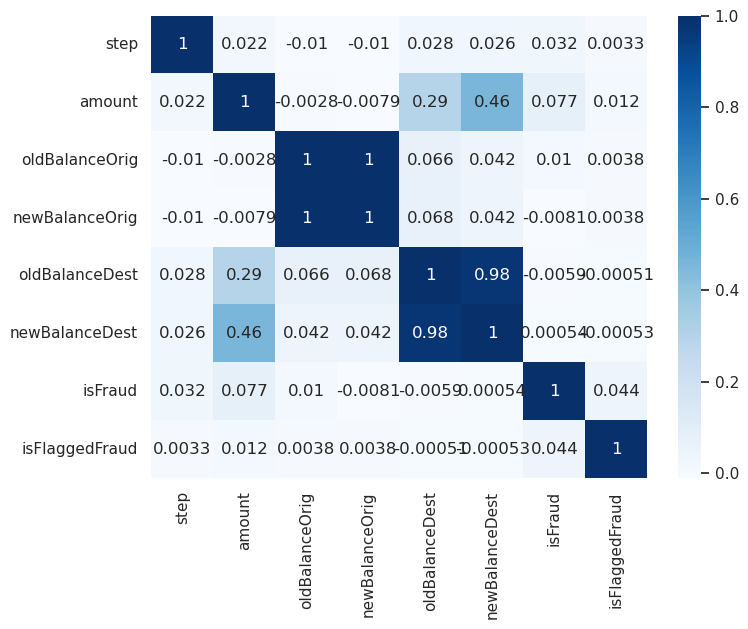

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

### Feature Selection

In [45]:
df_selected = df.loc[(df["type"] == "TRANSFER") | (df["type"] == "CASH_OUT")]

In [46]:
df_selected = df_selected.drop(["step", "nameOrig", "nameDest", "isFlaggedFraud"], axis = 1)

### Handling Categorical Variable

In [47]:
df_encoded = pd.get_dummies(df_selected,prefix=["type"])

In [48]:
df_encoded.head()

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
2,181.00,181.0,0.0,0.0,0.00,1,0,1
3,181.00,181.0,0.0,21182.0,0.00,1,1,0
15,229133.94,15325.0,0.0,5083.0,51513.44,0,1,0
19,215310.30,705.0,0.0,22425.0,0.00,0,0,1
24,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1


### Train-Test Splitting

In [49]:
randomState = 42
np.random.seed(randomState)

x = df_encoded.drop("isFraud", axis = 1)
y = df_encoded["isFraud"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Keep x_test and y_test to evaluate models with the test data once we built the model.

## Model Building

In [50]:
df_results = pd.DataFrame(columns=['Methodology', 'Model', 'Accuracy', 'Recall', 'Precision', 'ROC_value', 'Threshold'])

In [51]:
def show_confusion_matrix(y_test, pred_test):
    cm = confusion_matrix(y_test, pred_test)
    cm_df = pd.DataFrame(data=cm, columns =['P No', 'P Yes'], index = ['A No', 'A Yes'])
    print(cm_df)

In [52]:
def buildAndRunLogisticModels(df_results, Methodology, x_train, y_train, x_test, y_test):
    from sklearn import linear_model
    from sklearn.model_selection import KFold

    num_C = list(np.power(10.0, np.arange(-10, 10)))
    cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

    searchCV_l2 = linear_model.LogisticRegressionCV(
          Cs= num_C,
          penalty='l2',
          scoring='roc_auc',
          cv=cv_num,
          random_state=42,
          max_iter=10000,
          fit_intercept=True,
          solver='newton-cg',
          tol=10
      )

    searchCV_l1 = linear_model.LogisticRegressionCV(
          Cs=num_C,
          penalty='l1',
          scoring='roc_auc',
          cv=cv_num,
          random_state=42,
          max_iter=10000,
          fit_intercept=True,
          solver='liblinear',
          tol=10
      )

    searchCV_l1.fit(x_train, y_train)
    searchCV_l2.fit(x_train, y_train)
    print ('Max auc_roc for l1:', searchCV_l1.scores_[1].mean(axis=0).max())
    print ('Max auc_roc for l2:', searchCV_l2.scores_[1].mean(axis=0).max())

    #find predicted vallues
    y_pred_l1 = searchCV_l1.predict(x_test)
    y_pred_l2 = searchCV_l2.predict(x_test)


    #Find predicted probabilities
    y_pred_probs_l1 = searchCV_l1.predict_proba(x_test)[:,1] 
    y_pred_probs_l2 = searchCV_l2.predict_proba(x_test)[:,1] 

    # Accuaracy of L2/L1 models
    accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
    accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)
    
    #Recall of L2/L1 models
    recall_l2 = metrics.recall_score(y_pred=y_pred_l2, y_true=y_test)
    recall_l1 = metrics.recall_score(y_pred=y_pred_l1, y_true=y_test)
    
    #Precision of L2/L1 models
    precision_l2 = metrics.precision_score(y_pred=y_pred_l2, y_true=y_test)
    precision_l1 = metrics.precision_score(y_pred=y_pred_l1, y_true=y_test)

    print("Accuracy of Logistic model with l2 regularisation : {0}".format(accuracy_l2))
    print("Confusion Matrix")
    show_confusion_matrix(y_test, y_pred_l2)
    print('-' * 60)
    print("Classification Report")
    print(classification_report(y_test, y_pred_l2))

    print("Accuracy of Logistic model with l1 regularisation : {0}".format(accuracy_l1))
    print("Confusion Matrix")
    show_confusion_matrix(y_test, y_pred_l1)
    print('-' * 60)
    print("Classification Report")
    print(classification_report(y_test, y_pred_l1))

    l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
    print("l2 roc_value: {0}" .format(l2_roc_value))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print("l2 threshold: {0}".format(threshold))

    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    df_results = df_results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'Logistic Regression with L2 Regularisation','Accuracy': accuracy_l2,'Recall': recall_l2,'Precision':precision_l2,'ROC_value': l2_roc_value,'Threshold': threshold}, index=[0]),ignore_index= True)

    l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
    print("l1 roc_value: {0}" .format(l1_roc_value))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print("l1 threshold: {0}".format(threshold))

    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    df_results = df_results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'Logistic Regression with L1 Regularisation','Accuracy': accuracy_l1,'Recall': recall_l1,'Precision':precision_l1,'ROC_value': l1_roc_value,'Threshold': threshold}, index=[0]),ignore_index= True)
    return df_results

In [53]:
def buildAndRunXGBoostModels(df_results, Methodology, x_train, y_train, x_test, y_test):
    #Evaluate XGboost model
    XGBmodel = XGBClassifier(random_state=42)
    XGBmodel.fit(x_train, y_train)
    y_pred = XGBmodel.predict(x_test)

    XGB_test_score = XGBmodel.score(x_test, y_test)
    print('Model Accuracy: {0}'.format(XGB_test_score))
    
    #Recall of XGBoost model
    recall_xgb = metrics.recall_score(y_pred=y_pred, y_true=y_test)

    #Precision of XGBoost model
    precision_xgb = metrics.precision_score(y_pred=y_pred, y_true=y_test)

    print("Confusion Matrix")
    show_confusion_matrix(y_test, y_pred)
    print('-' * 60)
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    # Probabilities for each class
    XGB_probs = XGBmodel.predict_proba(x_test)[:, 1]

    # Calculate roc auc
    XGB_roc_value = roc_auc_score(y_test, XGB_probs)

    print("XGboost roc_value: {0}" .format(XGB_roc_value))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print("XGBoost threshold: {0}".format(threshold))
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    df_results = df_results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'XGBoost','Accuracy': XGB_test_score,'Recall': recall_xgb,'Precision':precision_xgb,'ROC_value': XGB_roc_value,'Threshold': threshold}, index=[0]),ignore_index= True)

    return df_results

In [54]:
def buildAndRunKNNModels(df_results, Methodology, x_train, y_train, x_test, y_test):
    #create KNN model and fit the model with train dataset
    knn = KNeighborsClassifier(n_neighbors = 5,n_jobs=16)
    knn.fit(x_train,y_train)
    score = knn.score(x_test,y_test)
    print("model score")
    print(score)

    #Accuracy
    y_pred = knn.predict(x_test)
    KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
    
    #Recall of KNN model
    recall_knn = metrics.recall_score(y_pred=y_pred, y_true=y_test)

    #Precision of KNN model
    precision_knn = metrics.precision_score(y_pred=y_pred, y_true=y_test)
    
    print("Confusion Matrix")
    show_confusion_matrix(y_test, y_pred)
    print('-' * 60)
    print("Classification Report")
    print(classification_report(y_test, y_pred))

    knn_probs = knn.predict_proba(x_test)[:, 1]

    # Calculate roc auc
    knn_roc_value = roc_auc_score(y_test, knn_probs)
    print("KNN roc_value: {0}" .format(knn_roc_value))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print("KNN threshold: {0}".format(threshold))

    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    df_results = df_results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'KNN','Accuracy': score,'Recall': recall_knn,'Precision':precision_knn,'ROC_value': knn_roc_value,'Threshold': threshold}, index=[0]),ignore_index= True)

    return df_results

### Stratified KFold

In [55]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)
# x is the feature set and y is the target
for train_index, test_index in skf.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train_SKF_cv, x_test_SKF_cv = x.iloc[train_index], x.iloc[test_index]
    y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 553977  553978  553979 ... 2770406 2770407 2770408] TEST: [     0      1      2 ... 661800 661801 661828]
TRAIN: [      0       1       2 ... 2770406 2770407 2770408] TEST: [ 553977  553978  553979 ... 1729827 1729828 1729889]
TRAIN: [      0       1       2 ... 2770406 2770407 2770408] TEST: [1107160 1107161 1107162 ... 2624073 2624078 2624079]
TRAIN: [      0       1       2 ... 2770406 2770407 2770408] TEST: [1660492 1660493 1660494 ... 2721116 2721254 2721255]
TRAIN: [      0       1       2 ... 2721116 2721254 2721255] TEST: [2213710 2213711 2213712 ... 2770406 2770407 2770408]


Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.9549411798096739
Max auc_roc for l2: 0.6659959700556891
Accuracy of Logistic model with l2 regularisation : 0.9970365343695236
Confusion Matrix
         P No  P Yes
A No   552439      0
A Yes    1642      0
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.00      0.00      0.00      1642

    accuracy                           1.00    554081
   macro avg       0.50      0.50      0.50    554081
weighted avg       0.99      1.00      1.00    554081

Accuracy of Logistic model with l1 regularisation : 0.9977097211418547
Confusion Matrix
         P No  P Yes
A No   552423     16
A Yes    1253    389
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.0

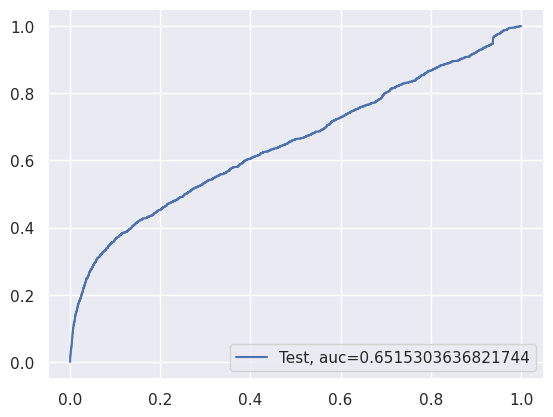

l1 roc_value: 0.91269531405586
l1 threshold: 0.009216130158196865
ROC for the test dataset 91.3%


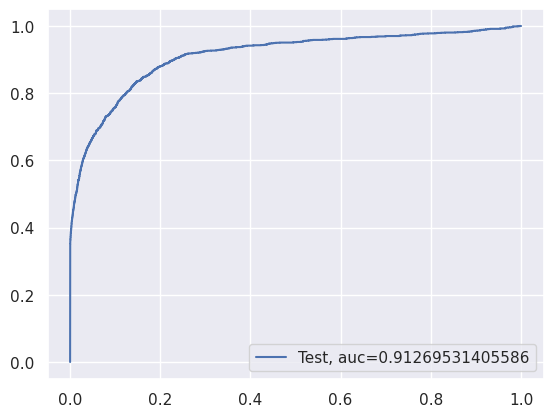

Time Taken by Model: --- 730.2219462394714 seconds ---
------------------------------------------------------------


In [56]:
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_results = buildAndRunLogisticModels(df_results, "StratifiedKFold Cross Validation", x_train_SKF_cv, y_train_SKF_cv, x_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 60 )

XGBoost Model
Model Accuracy: 0.9993611042428815
Confusion Matrix
         P No  P Yes
A No   552383     56
A Yes     298   1344
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.96      0.82      0.88      1642

    accuracy                           1.00    554081
   macro avg       0.98      0.91      0.94    554081
weighted avg       1.00      1.00      1.00    554081

XGboost roc_value: 0.9998929561436206
XGBoost threshold: 0.02536499686539173
ROC for the test dataset 100.0%


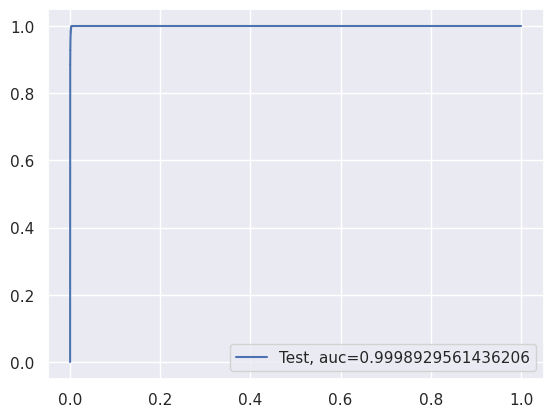

Time Taken by Model: --- 84.75247001647949 seconds ---


In [57]:
print("XGBoost Model")
start_time = time.time()
df_results = buildAndRunXGBoostModels(df_results, "StratifiedKFold Cross Validation", x_train_SKF_cv, y_train_SKF_cv, x_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

KNN Model
model score
0.9989857078658174
Confusion Matrix
         P No  P Yes
A No   552311    128
A Yes     434   1208
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.90      0.74      0.81      1642

    accuracy                           1.00    554081
   macro avg       0.95      0.87      0.91    554081
weighted avg       1.00      1.00      1.00    554081

KNN roc_value: 0.9305055999491869
KNN threshold: 0.2
ROC for the test dataset 93.1%


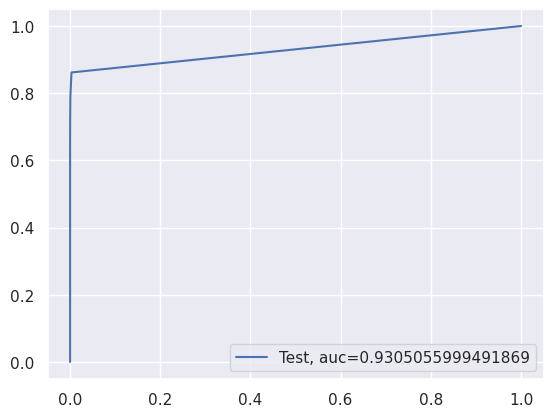

Time Taken by Model: --- 42.14301347732544 seconds ---
------------------------------------------------------------


In [58]:
print("KNN Model")
start_time = time.time()
df_results = buildAndRunKNNModels(df_results, "StratifiedKFold Cross Validation", x_train_SKF_cv, y_train_SKF_cv, x_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))
print('-' * 60 )

In [59]:
df_results

,Methodology,Model,Accuracy,Recall,Precision,ROC_value,Threshold
0,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.997037,0.000000,0.000000,0.651530,0.461419
1,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.997710,0.236906,0.960494,0.912695,0.009216
2,StratifiedKFold Cross Validation,XGBoost,0.999361,0.818514,0.960000,0.999893,0.025365
3,StratifiedKFold Cross Validation,KNN,0.998986,0.735688,0.904192,0.930506,0.200000


### SMOTE Oversampling with StratifiedKFold Cross Validation

In [60]:
from sklearn.model_selection import StratifiedKFold
from imblearn import over_sampling

In [61]:
cols = list(x.columns.values)

In [62]:
skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(x,y), 1):  
    x_train_SKF_cv, x_test_SKF_cv = x.iloc[train_index], x.iloc[test_index]
    y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]
    SMOTE = over_sampling.SMOTE(random_state=0)
    x_train_Smote, y_train_Smote = SMOTE.fit_resample(x_train_SKF_cv, y_train_SKF_cv)
  
x_train_Smote = pd.DataFrame(data=x_train_Smote, columns=cols)

In [63]:
Data_Imbalance_Handling = "SMOTE Oversampling with StratifiedKFold CV"

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9772534984826668
Accuracy of Logistic model with l2 regularisation : 0.9176150822441443
Confusion Matrix
         P No  P Yes
A No   506858  45578
A Yes      70   1576
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    552436
           1       0.03      0.96      0.06      1646

    accuracy                           0.92    554082
   macro avg       0.52      0.94      0.51    554082
weighted avg       1.00      0.92      0.95    554082

Accuracy of Logistic model with l1 regularisation : 0.9970293205698796
Confusion Matrix
         P No  P Yes
A No   552436      0
A Yes    1646      0
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00    

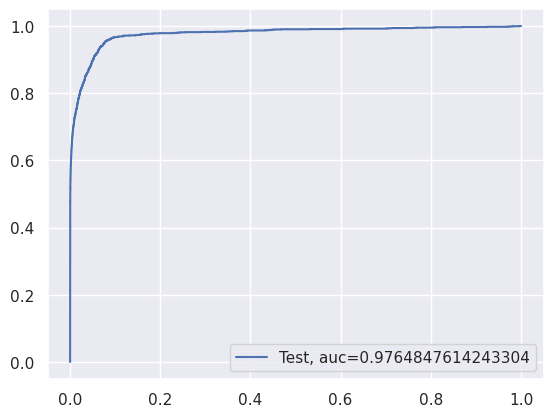

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


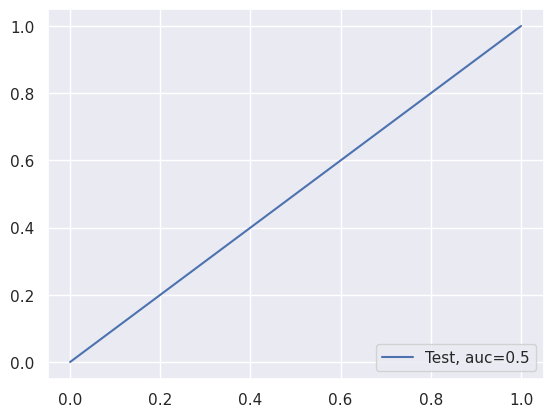

Time Taken by Model: --- 1189.5817050933838 seconds ---


In [64]:
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_results = buildAndRunLogisticModels(df_results, Data_Imbalance_Handling, x_train_Smote, y_train_Smote, x_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

XGBoost Model
Model Accuracy: 0.996545637649301
Confusion Matrix
         P No  P Yes
A No   550530   1906
A Yes       8   1638
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.46      1.00      0.63      1646

    accuracy                           1.00    554082
   macro avg       0.73      1.00      0.81    554082
weighted avg       1.00      1.00      1.00    554082

XGboost roc_value: 0.9992321504611846
XGBoost threshold: 0.527604877948761
ROC for the test dataset 99.9%


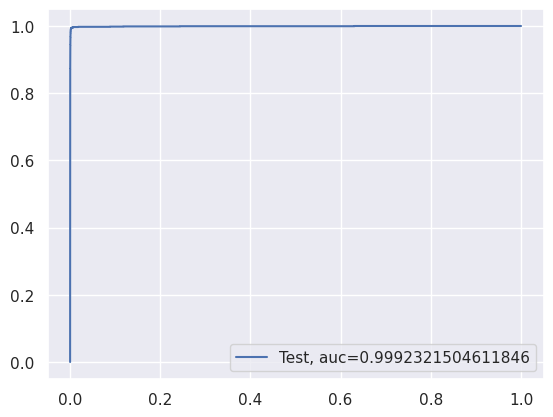

Time Taken by Model: --- 73.04411196708679 seconds ---


In [65]:
print("XGBoost Model")
start_time = time.time()
df_results = buildAndRunXGBoostModels(df_results, Data_Imbalance_Handling, x_train_Smote, y_train_Smote, x_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

KNN Model
model score
0.9928656769214665
Confusion Matrix
         P No  P Yes
A No   548516   3920
A Yes      33   1613
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    552436
           1       0.29      0.98      0.45      1646

    accuracy                           0.99    554082
   macro avg       0.65      0.99      0.72    554082
weighted avg       1.00      0.99      0.99    554082

KNN roc_value: 0.9906559641768502
KNN threshold: 0.6
ROC for the test dataset 99.1%


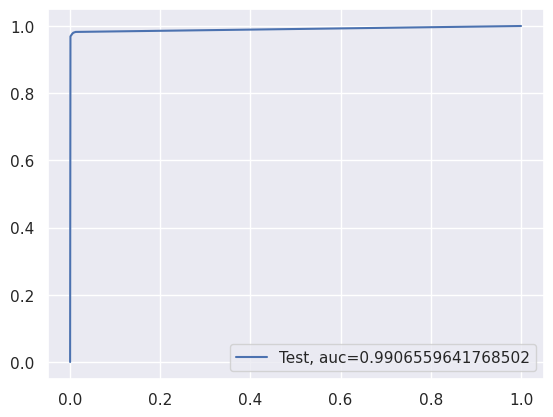

Time Taken by Model: --- 49.98242497444153 seconds ---


In [66]:
print("KNN Model")
start_time = time.time()
df_results = buildAndRunKNNModels(df_results, Data_Imbalance_Handling, x_train_Smote, y_train_Smote, x_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [67]:
df_results

,Methodology,Model,Accuracy,Recall,Precision,ROC_value,Threshold
0,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.997037,0.000000,0.000000,0.651530,0.461419
1,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.997710,0.236906,0.960494,0.912695,0.009216
2,StratifiedKFold Cross Validation,XGBoost,0.999361,0.818514,0.960000,0.999893,0.025365
3,StratifiedKFold Cross Validation,KNN,0.998986,0.735688,0.904192,0.930506,0.200000
4,SMOTE Oversampling with StratifiedKFold CV,Logistic Regression with L2 Regularisation,0.917615,0.957473,0.033422,0.976485,0.503433
5,SMOTE Oversampling with StratifiedKFold CV,Logistic Regression with L1 Regularisation,0.997029,0.000000,0.000000,0.500000,1.500000
6,SMOTE Oversampling with StratifiedKFold CV,XGBoost,0.996546,0.995140,0.462190,0.999232,0.527605
7,SMOTE Oversampling with StratifiedKFold CV,KNN,0.992866,0.979951,0.291524,0.990656,0.600000


### Random Oversampling with StratifiedKFold Cross Validation

In [68]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits=5, random_state=None)

for fold, (train_index, test_index) in enumerate(skf.split(x,y), 1):
    x_train_over, x_test_over = x.iloc[train_index], x.iloc[test_index]
    y_train_over, y_test_over = y.iloc[train_index], y.iloc[test_index]
    ROS = RandomOverSampler(sampling_strategy=0.5)
    x_over, y_over= ROS.fit_resample(x_train_over, y_train_over)
  
x_over = pd.DataFrame(data=x_over, columns=cols)

In [69]:
Data_Imbalance_Handling = "Random Oversampling with StratifiedKFold CV"

Logistic Regression with L1 And L2 Regularisation
Max auc_roc for l1: 0.5
Max auc_roc for l2: 0.9388765579211386
Accuracy of Logistic model with l2 regularisation : 0.9123198371360196
Confusion Matrix
         P No  P Yes
A No   504030  48406
A Yes     176   1470
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    552436
           1       0.03      0.89      0.06      1646

    accuracy                           0.91    554082
   macro avg       0.51      0.90      0.51    554082
weighted avg       1.00      0.91      0.95    554082

Accuracy of Logistic model with l1 regularisation : 0.9970293205698796
Confusion Matrix
         P No  P Yes
A No   552436      0
A Yes    1646      0
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00    

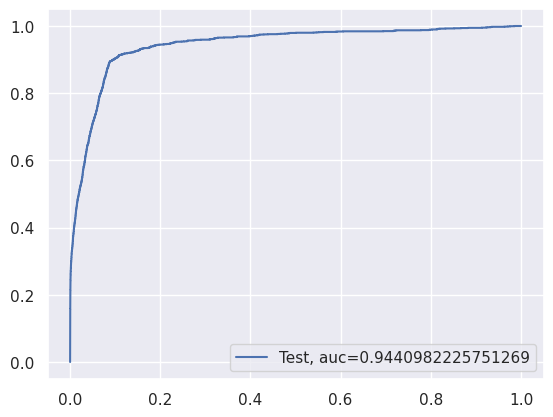

l1 roc_value: 0.5
l1 threshold: 1.5
ROC for the test dataset 50.0%


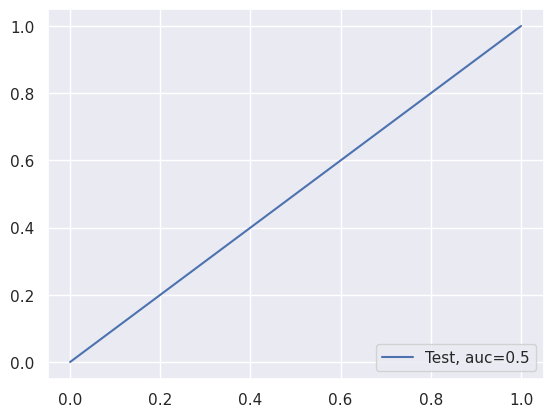

Time Taken by Model: --- 838.2999446392059 seconds ---


In [70]:
print("Logistic Regression with L1 And L2 Regularisation")
start_time = time.time()
df_results = buildAndRunLogisticModels(df_results, Data_Imbalance_Handling, x_over, y_over, x_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

XGBoost Model
Model Accuracy: 0.9965528567973694
Confusion Matrix
         P No  P Yes
A No   550535   1901
A Yes       9   1637
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.46      0.99      0.63      1646

    accuracy                           1.00    554082
   macro avg       0.73      1.00      0.81    554082
weighted avg       1.00      1.00      1.00    554082

XGboost roc_value: 0.9979535777633928
XGBoost threshold: 0.4166105389595032
ROC for the test dataset 99.8%


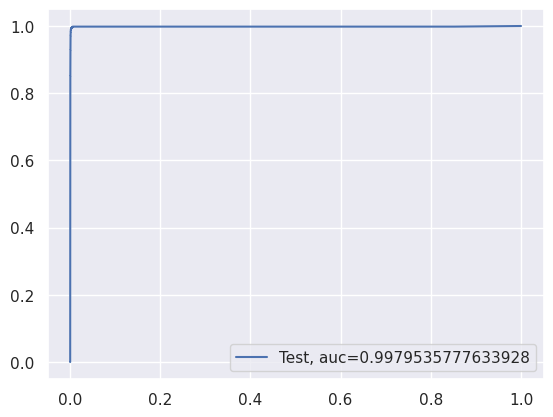

Time Taken by Model: --- 119.93153285980225 seconds ---


In [71]:
print("XGBoost Model")
start_time = time.time()
df_results = buildAndRunXGBoostModels(df_results, Data_Imbalance_Handling, x_over, y_over, x_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

KNN Model
model score
0.9984532975263589
Confusion Matrix
         P No  P Yes
A No   551640    796
A Yes      61   1585
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.67      0.96      0.79      1646

    accuracy                           1.00    554082
   macro avg       0.83      0.98      0.89    554082
weighted avg       1.00      1.00      1.00    554082

KNN roc_value: 0.9843824824620581
KNN threshold: 0.2
ROC for the test dataset 98.4%


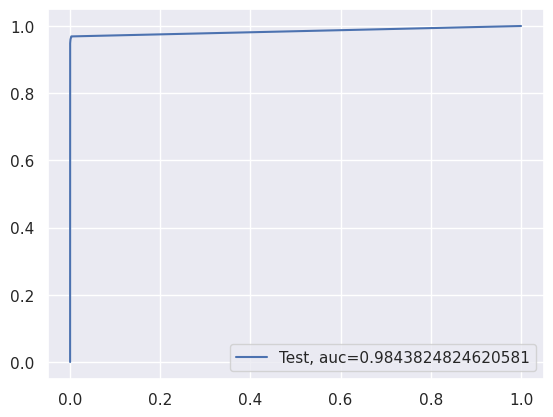

Time Taken by Model: --- 47.30444002151489 seconds ---


In [72]:
print("KNN Model")
start_time = time.time()
df_results = buildAndRunKNNModels(df_results, Data_Imbalance_Handling, x_over, y_over, x_test, y_test)
print("Time Taken by Model: --- %s seconds ---" % (time.time() - start_time))

In [73]:
df_results

,Methodology,Model,Accuracy,Recall,Precision,ROC_value,Threshold
0,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularisation,0.997037,0.000000,0.000000,0.651530,0.461419
1,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularisation,0.997710,0.236906,0.960494,0.912695,0.009216
2,StratifiedKFold Cross Validation,XGBoost,0.999361,0.818514,0.960000,0.999893,0.025365
3,StratifiedKFold Cross Validation,KNN,0.998986,0.735688,0.904192,0.930506,0.200000
4,SMOTE Oversampling with StratifiedKFold CV,Logistic Regression with L2 Regularisation,0.917615,0.957473,0.033422,0.976485,0.503433
5,SMOTE Oversampling with StratifiedKFold CV,Logistic Regression with L1 Regularisation,0.997029,0.000000,0.000000,0.500000,1.500000
6,SMOTE Oversampling with StratifiedKFold CV,XGBoost,0.996546,0.995140,0.462190,0.999232,0.527605
7,SMOTE Oversampling with StratifiedKFold CV,KNN,0.992866,0.979951,0.291524,0.990656,0.600000
8,Random Oversampling with StratifiedKFold CV,Logistic Regression with L2 Regularisation,0.912320,0.893074,0.029473,0.944098,0.498648
9,Random Oversampling with StratifiedKFold CV,Logistic Regression with L1 Regularisation,0.997029,0.000000,0.000000,0.500000,1.500000


### Hyperparameter Tuning

In [74]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [75]:
estimator = KNeighborsClassifier()

parameters = {
    'leaf_size': range(1,50),
    'n_neighbors': range(1,30),
    'p': [1,2]
}

randomized_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=parameters,
    scoring='roc_auc',
    n_jobs=8,
    cv=3,
    verbose=True
)

randomized_search.fit(x_over, y_over)
randomized_search.best_estimator_
randomized_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'p': 1, 'n_neighbors': 25, 'leaf_size': 25}

In [76]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range(2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

randomized_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=parameters,
    scoring='roc_auc',
    n_jobs=8,
    cv=3,
    verbose=True
)

randomized_search.fit(x_over, y_over)
randomized_search.best_estimator_
randomized_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'n_estimators': 180, 'max_depth': 6, 'learning_rate': 0.1}

In [77]:
knn = KNeighborsClassifier(p=1, n_neighbors=22, leaf_size=12)
knn.fit(x_over,y_over)
score = knn.score(x_test,y_test)

#Accuracy
y_pred = knn.predict(x_test)
KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
print('Model Accuracy: {}'.format(KNN_Accuracy))

#Recall of KNN model
recall_knn = metrics.recall_score(y_pred=y_pred, y_true=y_test)
print("RECALL: {}".format(recall_knn))

#Precision of KNN model
precision_knn = metrics.precision_score(y_pred=y_pred, y_true=y_test)
print("PRECISION: {}".format(precision_knn))

print("Confusion Matrix")
show_confusion_matrix(y_test, y_pred)
print('-' * 60)
print("Classification Report")
print(classification_report(y_test, y_pred))

knn_probs = knn.predict_proba(x_test)[:, 1]

# Calculate roc auc
knn_roc_value = roc_auc_score(y_test, knn_probs)
print("ROC_AUC_Score: {}".format(knn_roc_value))

Model Accuracy: 0.9944105746080905
RECALL: 0.9787363304981774
PRECISION: 0.34474641557885727
Confusion Matrix
         P No  P Yes
A No   549374   3062
A Yes      35   1611
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    552436
           1       0.34      0.98      0.51      1646

    accuracy                           0.99    554082
   macro avg       0.67      0.99      0.75    554082
weighted avg       1.00      0.99      1.00    554082

ROC_AUC_Score: 0.9912540948536898


In [83]:
XGBmodel = XGBClassifier(n_estimators=180, max_depth=8, learning_rate=0.1)
XGBmodel.fit(x_over, y_over)
y_pred = XGBmodel.predict(x_test)

XGB_test_score = XGBmodel.score(x_test, y_test)
print('Model Accuracy: {}'.format(XGB_test_score))

#Recall of XGBoost model
recall_xgb = metrics.recall_score(y_pred=y_pred, y_true=y_test)
print("RECALL: {}".format(recall_xgb))

#Precision of XGBoost model
precision_xgb = metrics.precision_score(y_pred=y_pred, y_true=y_test)
print("PRECISION: {}".format(precision_xgb))

print("Confusion Matrix")
show_confusion_matrix(y_test, y_pred)
print('-' * 60)
print("Classification Report")
print(classification_report(y_test, y_pred))

# Probabilities for each class
XGB_probs = XGBmodel.predict_proba(x_test)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test, XGB_probs)
print("ROC_AUC_Score: {}".format(XGB_roc_value))

Model Accuracy: 0.9988268884388953
RECALL: 0.9981773997569866
PRECISION: 0.7174672489082969
Confusion Matrix
         P No  P Yes
A No   551789    647
A Yes       3   1643
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.72      1.00      0.83      1646

    accuracy                           1.00    554082
   macro avg       0.86      1.00      0.92    554082
weighted avg       1.00      1.00      1.00    554082

ROC_AUC_Score: 0.9999720579234672


In [90]:
XGBmodel.feature_importances_

array([0.06746731, 0.23883581, 0.44735843, 0.00760754, 0.1803395 ,
       0.05839138, 0.        ], dtype=float32)

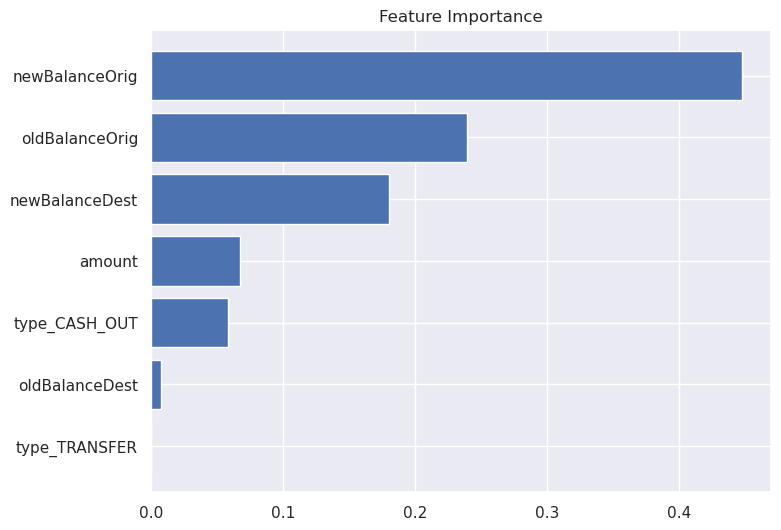

In [99]:
feature_importance = XGBmodel.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()